# Perform online segmentation

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ../dev/
from dataset_creation_aprovis3d import aprovis3dDataset

/home/antoine/homhots/aprovhots/dev


In [4]:
import tonic, torch, os, pickle, copy, sys
from tqdm import tqdm
from hots.network import network
from hots.layer import mlrlayer
from hots.timesurface import timesurface
from hots.utils import apply_jitter, get_loader, get_dataset_info, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import imageio.v3 as iio
from IPython.display import Image
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

data_path = '../../Data/RGB_frames2events/'
# gives the data type - here we use experimental data, stored as npy

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [5]:
from hots.layer import hotslayer
from tqdm import tqdm
from hots.timesurface import timesurface
from hots.utils import entropy
import numpy as np
import matplotlib.pyplot as plt
import torch, os
import pickle


class network_pooling(object):

    def __init__(self,  name,
                        dataset_name,
                        timestr, # date of creation of the network 
                        sensor_size, # 
                        nb_neurons = (4,8,16), # architecture of the network (default=Lagorce2017)
                        # parameters of time-surfaces and datasets
                        tau = (1e1,1e2,1e3), #time constant for exponential decay in millisec
                        R = (2,4,8), # parameter defining the spatial size of the time surface
                        homeo = True, # parameters for homeostasis (None is no homeo rule)
                        to_record = False,
                        record_path = '../Records/',
                        device = 'cuda',
                ):
        assert len(nb_neurons) == len(R) & len(nb_neurons) == len(tau)
        
        self.name = f'{timestr}_{dataset_name}_{name}_{homeo}_{nb_neurons}_{tau}_{R}'
        nb_layers = len(nb_neurons)
        self.n_pola = [nb_neurons[L] for L in range(nb_layers-1)]
        self.n_pola.insert(0,2)
        # pooling
        self.channel_size = [(sensor_size[0]//(2*R[L]+1)+1, sensor_size[1]//(2*R[L]+1)+1) for L in range(nb_layers-1)]
        self.channel_size.insert(0,(sensor_size[0], sensor_size[1]))
        self.tau = tau
        self.R = R
        self.record_path = record_path
        
        # pooling
        for L in range(nb_layers):
            assert (2*self.R[L]+1)**2 <= self.channel_size[L][0]*self.channel_size[L][1]
        
        path = self.record_path+'networks/'+self.name+'.pkl'
        if os.path.exists(path):
            with open(path, 'rb') as file:
                my_network = pickle.load(file)
            self.layers = my_network.layers
            for L in range(len(self.layers)):
                self.layers[L] = self.layers[L].to(device)
            
        else:
            self.layers = [hotslayer((2*R[L]+1)**2*self.n_pola[L], nb_neurons[L], homeostasis=homeo, device=device) for L in range(nb_layers)]
            
    def clustering(self, loader, ordering, filtering_threshold = None, ts_batch_size = None, device = 'cuda', record = False):
        path = self.record_path+'networks/'+self.name+'.pkl'
        if not os.path.exists(path):
            p_index = ordering.index('p')
            x_index = ordering.index('x')
            y_index = ordering.index('y')
            
            for L in range(len(self.tau)):
                self.layers[L] = self.layers[L].to(device)
                self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
            
            if record:
                entropy = []
                loss = []
                delta_w = []
                homeostasis = []

            with torch.no_grad():
                
                if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
                
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    if record:
                        previous_dic = [self.layers[L].synapses.weight.data.T.detach().clone() for L in range(len(self.tau))]
                    if ts_batch_size and len(events)>ts_batch_size:
                        nb_batch = len(events)//ts_batch_size+1
                        for L in range(len(self.tau)):
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, _ = self.layers[L](all_ts, True)
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_filtered_timesurface+load_nb*ts_batch_size]) if ind_outputs.shape[0]>0 else ind_filtered_timesurface
                                if record:
                                    proto_ts = all_ts.detach().clone()
                                    kernels = self.layers[L].synapses.weight.data.T
                                    DIFF = 0
                                    for ev in range(len(n_star)):
                                        proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                        diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                        DIFF += diff.mean()
                                    DIFF/=len(n_star)
                                    loss.append(DIFF.cpu())
                                    entropy.append(entropy(kernels))
                                    delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                    homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                            events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                            events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                            if events.shape[0]==0: break
                    else:    
                        for L in range(len(self.tau)):
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, _  = self.layers[L](all_ts, True)
                            if record:
                                proto_ts = all_ts.detach().clone()
                                kernels = self.layers[L].synapses.weight.data.T
                                DIFF = 0
                                for ev in range(len(n_star)):
                                    proto_ts[ev,:,:,:] = torch.reshape(kernels[:,int(n_star[ev].cpu())], (self.n_pola[L], 2*self.R[L]+1, 2*self.R[L]+1))
                                    diff = torch.linalg.norm(all_ts[ev,:,:,:]-proto_ts[ev,:,:,:])
                                    DIFF += diff.mean()
                                DIFF/=len(n_star)
                                loss.append(DIFF.cpu())
                                entropy.append(entropy(kernels))
                                delta_w.append((kernels-previous_dic[L]).abs().mean().cpu())
                                homeostasis.append((self.layers[L].cumhisto/self.layers[L].cumhisto.sum()-1/kernels.shape[1]).abs().mean().cpu())
                            del all_ts
                            torch.cuda.empty_cache()
                            
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                            events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                            events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                            if events.shape[0]==0: break

            with open(path, 'wb') as file:
                pickle.dump(self, file, pickle.HIGHEST_PROTOCOL)
            if record:
                path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
                with open(path, 'wb') as file:
                    pickle.dump([loss, entropy, delta_w, homeostasis], file, pickle.HIGHEST_PROTOCOL)
            
            
    def coding(self, loader, ordering, classes, training, ts_batch_size = None, filtering_threshold = None, jitter=(None,None), layer_threshold = None, device = 'cuda', verbose=True):
        
        #homeostatic gain control is used only for the clustering phase
        for L in range(len(self.tau)):
            self.layers[L].homeo_flag = False
            self.layers[L] = self.layers[L].to(device)
            self.layers[L].cumhisto = self.layers[L].cumhisto.to(device)
        
        if not filtering_threshold: filtering_threshold = [None for L in range(len(self.tau))]
        if not layer_threshold: layer_threshold = [None for L in range(len(self.tau))]
        
        p_index = ordering.index('p')
        x_index = ordering.index('x')
        y_index = ordering.index('y')
        
        if training:
            output_path = self.record_path+f'output/train/{self.name}_{len(loader)}_{jitter}/'
        else: output_path = self.record_path+f'output/test/{self.name}_{len(loader)}_{jitter}/'
        
        if os.path.exists(output_path):
            if verbose:
                print(f'this dataset have already been processed, check at: \n {output_path}')
        else:
            for classe in classes:
                os.makedirs(output_path+f'{classe}')
            
            with torch.no_grad():
                nb = 0
                for events, target in tqdm(loader):
                    events = events.squeeze(0)
                    if ts_batch_size and len(events)>ts_batch_size:
                        nb_batch = len(events)//ts_batch_size+1
                        for L in range(len(self.tau)):
                            previous_timestamp = []
                            outputs = torch.Tensor([])
                            ind_outputs = torch.Tensor([])
                            for load_nb in range(nb_batch):
                                all_ts, ind_filtered_timesurface, previous_timestamp = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], ts_batch_size = ts_batch_size, load_number = load_nb, previous_timestamp = previous_timestamp, device = device)
                                n_star, ind_filtered_layer = self.layers[L](all_ts, False)
                                ind_to_keep = ind_filtered_timesurface[ind_filtered_layer]
                                outputs = torch.hstack([outputs,n_star]) if outputs.shape[0]>0 else n_star
                                ind_outputs = torch.hstack([ind_outputs,ind_to_keep+load_nb*ts_batch_size]) if ind_outputs.shape[0]>0 else ind_to_keep
                                del all_ts
                                torch.cuda.empty_cache()
                            events = events[ind_outputs,:]
                            events[:,p_index] = outputs.cpu()
                            events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                            events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                            if events.shape[0]==0: 
                                complete_flag = False
                                break
                            else:
                                complete_flag = True
                    else:
                        for L in range(len(self.tau)):
                            all_ts, ind_filtered_timesurface = timesurface(events, (self.channel_size[L][0], self.channel_size[L][1], self.n_pola[L]), ordering, tau = self.tau[L], surface_dimensions=[2*self.R[L]+1,2*self.R[L]+1], filtering_threshold = filtering_threshold[L], device=device)
                            n_star, ind_filtered_layer = self.layers[L](all_ts, False)
                            events = events[ind_filtered_timesurface,:]
                            events[:,p_index] = n_star.cpu()
                            events = events[ind_filtered_layer,:]
                            events[:,x_index] = torch.div(events[:,x_index], (2*self.R[L]+1), rounding_mode='floor')
                            events[:,y_index] = torch.div(events[:,y_index], (2*self.R[L]+1), rounding_mode='floor')
                            del all_ts
                            torch.cuda.empty_cache()
                            if events.shape[0]==0: 
                                complete_flag = False
                                break
                            else:
                                complete_flag = True
                    if complete_flag:
                        np.save(output_path+f'{classes[target]}/{nb}', events)
                    nb+=1
                    
                    
    def plotlayers(self, maxpol=None, hisiz=2, yhis=0.3):
        '''
        '''
        N = []
        P = [2]
        R2 = []
        kernels = []
        for L in range(len(self.tau)):
            kernels.append(self.layers[L].synapses.weight.data.T.cpu().numpy())
            N.append(int(kernels[L].shape[1]))
            if L>0:
                P.append(int(kernels[L-1].shape[1]))
            R2.append(int(kernels[L].shape[0]/P[L]))
        if maxpol is None:
            maxpol=P[-1]

        fig = plt.figure(figsize=(16,9))
        gs = fig.add_gridspec(np.sum(P)+hisiz, np.sum(N)+len(self.tau)-1, wspace=0.05, hspace=0.05)
        if self.layers[-1].homeo_flag:
            fig.suptitle('Unsupervised clustering with homeostasis', size=20, y=0.95)
        else:
            fig.suptitle('Unsupervised clustering for original HOTS', size=20, y=0.95)

        for L in range(len(self.tau)):
            ax = fig.add_subplot(gs[:hisiz, int(np.sum(N[:L]))+1*L:int(np.sum(N[:L+1]))+L*1])
            plt.bar(np.arange(N[L]), (self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu(), width=1, align='edge', ec="k")
            ax.set_xticks(())
            ax.set_title('Layer '+str(L+1), fontsize=16)
            plt.xlim([0,N[L]])
            yhis = 1.1*max(self.layers[L].cumhisto/torch.sum(self.layers[L].cumhisto)).cpu()
            plt.ylim([0,yhis])

            for k in range(N[L]):
                vmaxi = max(kernels[L][:,k])
                for j in range(P[L]):
                    if j>maxpol-1:
                        pass
                    else:
                        axi = fig.add_subplot(gs[j+hisiz,k+1*L+int(np.sum(N[:L]))])
                        krnl = kernels[L][j*R2[L]:(j+1)*R2[L],k].reshape((int(np.sqrt(R2[L])), int(np.sqrt(R2[L]))))

                        axi.imshow(krnl, vmin=0, vmax=vmaxi, cmap=plt.cm.plasma, interpolation='nearest')
                        axi.set_xticks(())
                        axi.set_yticks(())
        plt.show()
        return fig
    
    def plotlearning(self, width_fig = 30):
        path = self.record_path+'networks/'+self.name+'_recorded_parameters.pkl'
        with open(path, 'rb') as file:
            loss, entropy, delta_w, homeostasis = pickle.load(file)
            
        n_layers = len(self.tau)
        fig, axs = plt.subplots(n_layers,4, figsize=(width_fig,n_layers*width_fig//4))
        for L in range(n_layers):
            loss_layer = loss[L::n_layers]
            entropy_layer = entropy[L::n_layers]
            delta_w_layer = delta_w[L::n_layers]
            homeostasis_layer = homeostasis[L::n_layers]
            axs[L,0].plot(loss_layer)
            axs[L,1].plot(entropy_layer)
            axs[L,2].plot(delta_w_layer)
            axs[L,3].plot(homeostasis_layer)
            if L == 0:
                axs[L,0].set_title('average loss')
                axs[L,1].set_title('average entropy values for the time surfaces')
                axs[L,2].set_title('average gradient of the weights')
                axs[L,3].set_title('average homeostasic gain')
        plt.show()

In [6]:
data_type = 'synthetic'
# gives a patch_size to divide spatially the event streams
patch_size = (672, 376)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = 1e3 # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea','gro']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [672, 376, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = .75
# gives the indexing of the event stream
ordering = 'xytp'

trainset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
testset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=False, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
trainloader = get_loader(trainset)
testloader = get_loader(testset)

num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(trainset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 69
number of samples in the testing set: 24


## Run the core HOTS network

In [8]:
name = 'homeohots_pool'
homeo = True
timestr = '2023-01-03'
dataset_name = 'aprovis_UCA_no_patch'
ts_batch_size = int(2e4)

tau_0 = 6e3
tau_0 = 2e4

Rz = [4, 8]
N_neuronz = [64, 64]
tauz = [tau_0*2, tau_0*64]

hots = network_pooling(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
    os.mkdir(record_path+'output/')
    os.mkdir(record_path+'output/train/')
    os.mkdir(record_path+'output/test/')
    os.mkdir(record_path+'LR_results/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(trainloader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size)

  0%|                                                                                                                                                                                                                                                  | 0/69 [00:00<?, ?it/s]

0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17
1 75 42 64 17 17


  1%|███▎                                                                                                                                                                                                                                   | 1/69 [07:33<8:33:41, 453.26s/it]

0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
0 672 376 2 9 9
1 75 42 64 17 17


  1%|███▎                                                                                                                                                                                                                                   | 1/69 [08:15<9:21:40, 495.59s/it]


KeyboardInterrupt: 

In [6]:
hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=True, ts_batch_size = ts_batch_size, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=False, ts_batch_size = ts_batch_size, verbose=False)

In [7]:
jitter = (None, None)
type_transform = tonic.transforms.NumpyAsType(int)
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/test/{hots.name}_{num_sample_test}_{jitter}/'
#trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
#testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)

## Divide the event streams into 16x16 patches

In [8]:
patch_size = (64, 64)
max_duration = None
min_num_events = 10
kfold = None

#weird way of splitting dataset between trainsets and testsets but works -> to improve
trainset_output = aprovis3dDataset(save_to=train_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
testset_output = aprovis3dDataset(save_to=test_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
trainloader_output = get_loader(trainset_output, kfold = kfold)
testloader_output = get_loader(testset_output)
print(f'number of samples in the training set: {len(trainloader_output)}')
print(f'number of samples in the testing set: {len(testloader_output)}')

number of samples in the training set: 3218
number of samples in the testing set: 1172


## Example with only one layer of Multinomial Logistic Regression (MLR)

In [9]:
ts_batch_size = int(1e3) 
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
betas = (0.9, 0.999)
num_epochs = 2 ** 5 + 1
N_polarities = N_neuronz[-1]
ts_size = (trainset_output.sensor_size[0],trainset_output.sensor_size[1],N_polarities)
tau_cla = 6e4*32
mlr_layer_name = f'{timestr}_LR_patches_{tau_cla}_{ts_size}_{learning_rate}_{betas}_{num_epochs}_{kfold}_{jitter}.pkl'

model_path = record_path+'networks/' + mlr_layer_name
results_path = record_path+'LR_results/' + mlr_layer_name
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/train/{hots.name}_{num_sample_test}_{jitter}/'

classif_layer, losses = fit_mlr(trainloader_output, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size,)

Number of chance decisions: 0
90th quantile for number of events: 11507.200000000008
Mean accuracy: 68.10000000000001%
Last accuracy: 61.3%
Highest probability accuracy: 56.10000000000001%


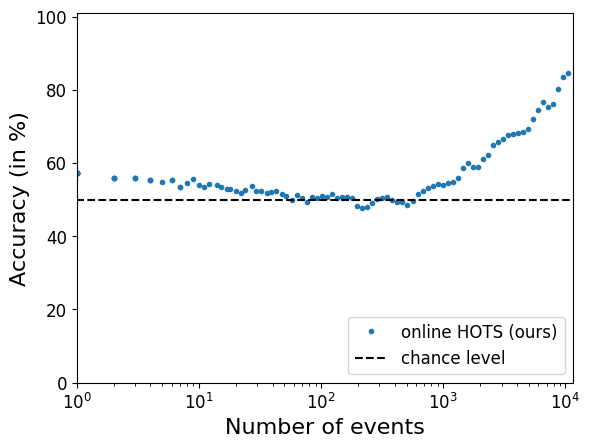

In [16]:
mlr_threshold = None

onlinac, best_probability, meanac, lastac  = online_accuracy(classif_layer, tau_cla, testloader_output, results_path, ts_size, trainset.ordering, len(labelz), mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, original_accuracy = None, original_accuracy_nohomeo = None, online_plot=True)

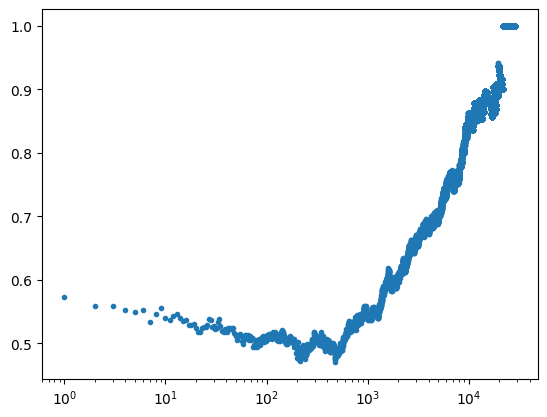

In [21]:
plt.semilogx(onlinac, '.')

[0.56399317 0.57337884 0.55887372 ... 1.         1.         1.        ]


NameError: name 'original_accuracy' is not defined

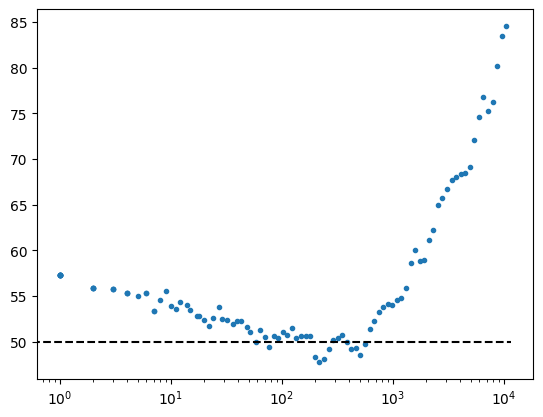

In [20]:
        percentile_90 = 11507
        fig, ax = plt.subplots()
        sampling = (np.logspace(0,np.log10(percentile_90),100)).astype(int)
        print(onlinac)
        ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
        ax.hlines(1/n_classes*100,0,int(percentile_90), linestyles='dashed', color='k', label='chance level')
        if original_accuracy:
            ax.hlines(original_accuracy*100,0,int(percentile_90), linestyles='dashed', color='g', label='HOTS with homeostasis')
        if original_accuracy_nohomeo:
            ax.hlines(original_accuracy_nohomeo*100,0,int(percentile_90), linestyles='dashed', color='r', label='original HOTS')
        ax.set_xlabel('Number of events', fontsize=16);
        ax.axis([1,int(percentile_90),0,101]);
        #plt.title('LR classification results evolution as a function of the number of events');
        plt.setp(ax.get_xticklabels(),fontsize=12)
        #ax.set_yticks([])
        plt.setp(ax.get_yticklabels(),fontsize=12)
        ax.legend(fontsize=12, loc='lower right');
        ax.set_ylabel('Accuracy (in %)', fontsize=16);
        if figure_name:
            printfig(fig, figure_name)

  0%|                                                                                                                                                                                                                                                | 0/1172 [00:00<?, ?it/s]/home/antoine/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antoine/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1172/1172 [08:03<00:00,  2.42it/s]
/home/antoine/homhots/hotsline/hots/utils.py:565: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


Mean accuracy: 64.4%


(0.6440369516186123,
 array([       nan, 0.52      , 0.6       , ..., 0.66521739, 0.66521739,
        0.66375546]),
 0.6143344709897611,
 1570231,
 867876)

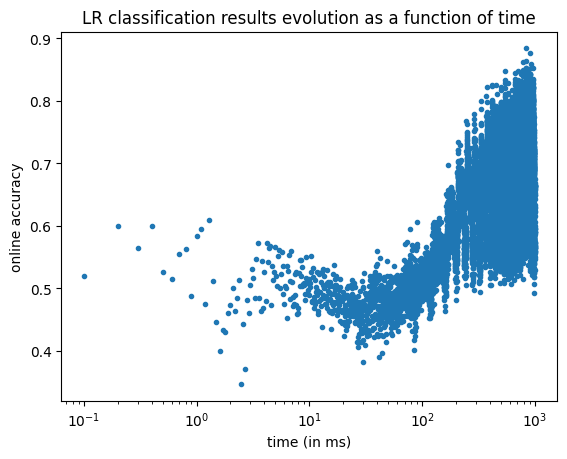

In [22]:
from hots.utils import score_classif_time
device = 'cuda'
timestep = 100
likelihood, true_target, timestamps = predict_mlr(classif_layer, tau_cla, testloader_output, results_path, ts_size, trainset.ordering, save=True, device=device, ts_batch_size=ts_batch_size)
score_classif_time(likelihood, true_target, timestamps, timestep, thres=mlr_threshold)